In [1]:
import tensorflow_privacy
import tensorflow as tf
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Importing Classifier Modules
import sklearn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(8,4)})

# Data Cleaning

1) We will increase the complexity of our model slightly by increasing the number of features. Keep the following features:

- T_degC (water temperature)
- Salnty (salinity of water)
- STheta (density of water)
- O2ml_L (milliliters of dissolved oxygen per liter of water)
- Depthm (depth in meters)

In [3]:
df = pd.read_csv('bottle.csv')

c:\Users\58386\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (47,73) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df = df[['T_degC','Salnty', 'STheta','O2ml_L','Depthm']]

In [5]:
df.head()

,T_degC,Salnty,STheta,O2ml_L,Depthm
0,10.50,33.440,25.649,NaN,0
1,10.46,33.440,25.656,NaN,8
2,10.46,33.437,25.654,NaN,10
3,10.45,33.420,25.643,NaN,19
4,10.45,33.421,25.643,NaN,20


2) Remove NaN / NA values from dataset (prior to building train/test sets) (same as HW #1):
- Shape of your data should be: (661268, 5)


In [6]:
df = df.dropna()
df.shape

(661268, 5)

3) Remove any STheta outliers (same as HW #1).
- Shape of your data should be: (661268, 5)
- Note: Outliers for STheta might have been removed due to NAs in new features. Be sure to verify this on your own.

C:\Users\58386\AppData\Local\Temp/ipykernel_25904/2588158861.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


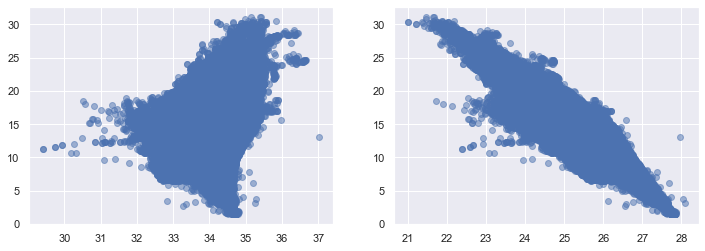

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(df.Salnty, df.T_degC, alpha=0.5)

ax[1].scatter(df.STheta, df.T_degC, alpha=0.5)

fig.show()

In [8]:
df = df[df['STheta']<200]
df.shape
# Outliers for STheta have been removed due to NAs in new features. 

(661268, 5)

In [9]:
df.to_csv('data.csv',index=False)

# Introduce incorrect data/outliers/gaps

In [19]:
pd.read_csv('data.csv')
df.describe()

,T_degC,Salnty,STheta,O2ml_L,Depthm
count,661268.000000,661268.000000,661268.000000,661268.000000,661268.00000
mean,10.917560,33.832800,25.797882,3.416076,219.73400
std,4.224529,0.460338,1.009609,2.068615,311.15039
min,1.440000,29.402000,20.996000,-0.010000,0.00000
25%,7.800000,33.480000,24.941000,1.400000,49.00000
50%,10.160000,33.854000,25.972000,3.470000,125.00000
75%,14.010000,34.184800,26.634000,5.510000,300.00000
max,31.140000,37.034000,28.083000,11.130000,5351.00000


In [34]:
# introduce 10% total data size of outliers
dirty_df = df.copy()

ncolumns = len(dirty_df.columns)

# num_dirty = round(len(df)*0.1)
num_dirty = 1000

for i in range(num_dirty):
    noise = np.random.randint(0 , 100 , ncolumns)
    #dirty_df.loc[len(dirty_df)+1]=noise
    dirty_df.loc[864862+i]=noise
    #df.append(noise)

In [35]:
df

,T_degC,Salnty,STheta,O2ml_L,Depthm
0,10.300,33.0300,25.36400,5.900,0
1,18.460,32.9200,23.56800,6.020,6
2,10.290,32.9510,25.30400,6.040,10
3,10.290,32.9900,25.33500,6.060,15
4,10.330,33.0050,25.33900,6.040,20
...,...,...,...,...,...
661263,18.744,33.4083,23.87055,5.805,0
661264,18.744,33.4083,23.87072,5.805,2
661265,18.692,33.4150,23.88911,5.796,5
661266,18.161,33.4062,24.01426,5.816,10


In [36]:
dirty_df

,T_degC,Salnty,STheta,O2ml_L,Depthm
0,10.30,33.030,25.364,5.90,0
1,18.46,32.920,23.568,6.02,6
2,10.29,32.951,25.304,6.04,10
3,10.29,32.990,25.335,6.06,15
4,10.33,33.005,25.339,6.04,20
...,...,...,...,...,...
865857,61.00,72.000,15.000,37.00,11
865858,45.00,53.000,39.000,71.00,54
865859,92.00,0.000,61.000,20.00,79
865860,88.00,4.000,20.000,46.00,67


In [37]:
dirty_df.to_csv('data.csv',index=False)

## EDA

In [38]:
df = pd.read_csv('data.csv')

C:\Users\58386\AppData\Local\Temp/ipykernel_25904/2588158861.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


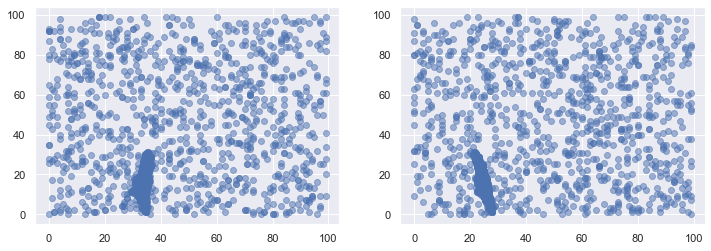

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(df.Salnty, df.T_degC, alpha=0.5)

ax[1].scatter(df.STheta, df.T_degC, alpha=0.5)

fig.show()

# Train / Test Split & Scaling

1) Create X & y objects:

- X object should be all 4 predictors. Shape should be: (661268, 4)

- y object should be just your target variable (T_degC): Shape should be: (661268, 1)

Hint for y: You will need to specify the shape you want. Trying converting y to a numpy array, and then using the .reshape() method.

In [40]:
# X,y=df.drop(['T_degC'],axis=1),df['T_degC']
X,y=df.drop(['T_degC'],axis=1),df['T_degC']

In [41]:
y.shape

(662268,)

2) Generate X_train, X_test, y_train & y_test. Use 80% for train & 20% for test.

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

 3) Scale all features to improve convergence in Gradient Descent. It is highly encouraged that you review the appropriate method of handling scaling with train & test data.

Additional info on scaling with train & test sets: https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i (Links to an external site.)

The easiest approach is to use the sklearn tool "StandardScaler" - more info here: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html (Links to an external site.)

You should create two new X objects:
- X_train_scaled
- X_test_scaled.

Note: X_test_scaled must use the scaling parameters learned from training data.

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)

In [44]:
X_train_scaled

array([[-0.62930277, -0.29820674,  0.29874584, -0.55558906],
       [ 0.13787139,  0.37417948, -0.48095512, -0.06225703],
       [-0.2129432 , -0.30334818,  0.45602458, -0.38792065],
       ...,
       [-0.16378447, -0.03770706,  0.03438371, -0.46530607],
       [ 0.1430852 ,  0.42559389, -0.32702274,  0.09896258],
       [-0.3224331 , -0.29420784,  0.48614178, -0.47820364]])

In [45]:
scaler = StandardScaler() 
scaler.fit(X_test)
X_test_scaled = scaler.fit_transform(X_test)

In [46]:
X_test_scaled

array([[-0.56931779, -0.49641804,  0.79135367, -0.46177364],
       [-0.36433815, -0.90518715,  0.7775509 , -0.6367304 ],
       [ 0.24532555, -0.32874599,  0.60501633, -0.27727378],
       ...,
       [ 0.38022024,  0.638382  , -0.97885107,  0.8806219 ],
       [-0.05234708,  0.20385934, -0.05751644, -0.22319623],
       [ 0.24607915,  0.50742246, -0.82011926,  0.25395858]])

## Build Linear Regression Model with sklearn

In [47]:
# fit model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [48]:
y_pred_sklearn = lin_reg.predict(X_test_scaled)
y_pred_train = lin_reg.predict(X_train_scaled)

In [49]:
# model evaluation

# test
test_mse = MSE(y_test, y_pred_sklearn)
print(f"Test set RMSE:", test_mse)


Test set RMSE: 7.369125780828034


In [50]:
def compare_three(y_test,y_pred,y_train,y_pred_train):
    test_mse = MSE(y_test, y_pred)
    train_mse = MSE(y_train, y_pred_train)
    print(f"Test set MSE:", test_mse)
    print(f"Train set MSE:", train_mse)

    test_r2=sklearn.metrics.r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')
    train_r2=sklearn.metrics.r2_score(y_train, y_pred_train, sample_weight=None, multioutput='uniform_average')

    print(f"Test set R2:", test_r2)
    print(f"Train set R2:", train_r2)

    test_ev= sklearn.metrics.explained_variance_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')
    train_ev= sklearn.metrics.explained_variance_score(y_train, y_pred_train, sample_weight=None, multioutput='uniform_average')

    print(f"Test set explained variance:", test_ev)
    print(f"Train set explained variance:", train_ev)

Test set MSE: 7.369125780828034
Train set MSE: 7.090300491562438
Test set R2: 0.6545877918273311
Train set R2: 0.6648971077320993
Test set explained variance: 0.654602787425427
Train set explained variance: 0.6648971077320993


Text(0, 0.5, 'y_pred')

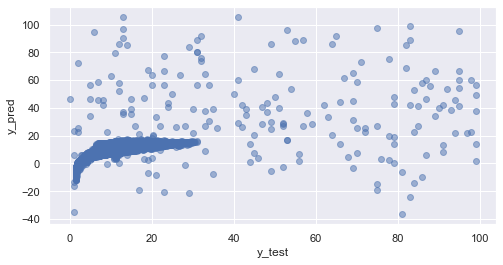

In [51]:
compare_three(y_test,y_pred_sklearn,y_train,y_pred_train)
plt.scatter(y_test, y_pred_sklearn, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')

# Clean Data Train / Test Split & Scaling

1) Create X & y objects:

- X object should be all 4 predictors. Shape should be: (661268, 4)

- y object should be just your target variable (T_degC): Shape should be: (661268, 1)

Hint for y: You will need to specify the shape you want. Trying converting y to a numpy array, and then using the .reshape() method.

In [62]:
# X,y=df.drop(['T_degC'],axis=1),df['T_degC']
df = pd.read_csv('bottle.csv')
df = df[['T_degC','Salnty', 'STheta','O2ml_L','Depthm']]
df = df.dropna()
df = df[df['STheta']<200]
X,y=df.drop(['T_degC'],axis=1),df['T_degC']

c:\Users\58386\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (47,73) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)

In [65]:
X_train_scaled

array([[-0.74540261, -0.63854348,  1.29855184, -0.67728002],
       [ 0.51244708,  0.78685534, -0.55823535,  0.09669652],
       [-0.2392213 ,  0.03800092,  0.02684603, -0.3047436 ],
       ...,
       [-0.43039708, -0.0303469 ,  0.08487063, -0.46531964],
       [ 0.46465313,  0.77298767, -0.43735077,  0.09669652],
       [-0.89312935, -0.47510303,  0.73764738, -0.47816573]])

In [66]:
scaler = StandardScaler() 
scaler.fit(X_test)
X_test_scaled = scaler.fit_transform(X_test)

In [67]:
X_test_scaled

array([[-0.74609439, -0.97622802,  1.17715695, -0.69982041],
       [ 0.85886281,  0.9804599 , -1.49343737,  0.51539716],
       [-1.28035619, -0.1107699 ,  0.71837492, -0.22275887],
       ...,
       [ 0.04661112, -0.01273746, -0.25714054, -0.25821615],
       [-1.58657942, -1.41885934,  1.32203548, -0.69982041],
       [-1.01539709, -0.55538168,  0.86808274, -0.42260898]])

## Build DP Model with TensorFlow

In [68]:
epochs = 3
batch_size = 250

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 1
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [69]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [70]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Dense(units=1, input_shape=[4])
])

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = [tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.Accuracy()])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
16532/16532 [==============================] - 15s 889us/step - loss: 4.9383 - mean_squared_error: 4.9383 - accuracy: 0.0000e+00
Epoch 2/5
16532/16532 [==============================] - 15s 887us/step - loss: 5.0699 - mean_squared_error: 5.0699 - accuracy: 0.0000e+00
Epoch 3/5
16532/16532 [==============================] - 17s 1ms/step - loss: 4.9664 - mean_squared_error: 4.9664 - accuracy: 0.0000e+00
Epoch 4/5
16532/16532 [==============================] - 15s 880us/step - loss: 4.8059 - mean_squared_error: 4.8059 - accuracy: 0.0000e+00
Epoch 5/5
16532/16532 [==============================] - 15s 885us/step - loss: 5.0824 - mean_squared_error: 5.0824 - accuracy: 0.0000e+00


In [71]:
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)


In [72]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=X_train_scaled.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.0473% and noise_multiplier = 1.3 iterated over 6349 steps satisfies differential privacy with eps = 0.319 and delta = 1e-05.
The optimal RDP order is 25.0.


(0.3194779414434474, 25.0)

Test set MSE: 2.1016769342315005
Train set MSE: 2.1297170815550417
Test set R2: 0.8823034136378252
Train set R2: 0.8806483081105175
Test set explained variance: 0.8997584601044581
Train set explained variance: 0.8989953680755515


Text(0, 0.5, 'y_pred')

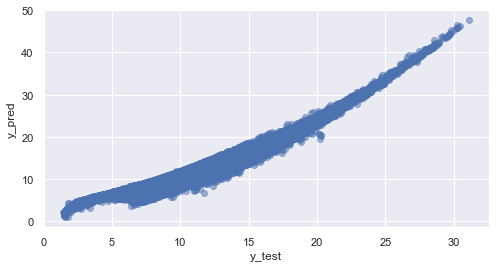

In [73]:
compare_three(y_test,y_pred,y_train,y_pred_train)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')

In [74]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Dense(units=1, input_shape=[4])
])

model.compile(optimizer='sgd', loss='mean_squared_error', metrics = [tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.Accuracy()])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
16532/16532 [==============================] - 15s 916us/step - loss: 0.3445 - mean_squared_error: 0.3445 - accuracy: 1.8903e-06
Epoch 2/5
16532/16532 [==============================] - 15s 918us/step - loss: 0.1115 - mean_squared_error: 0.1115 - accuracy: 3.7806e-06
Epoch 3/5
16532/16532 [==============================] - 15s 935us/step - loss: 0.1115 - mean_squared_error: 0.1115 - accuracy: 1.8903e-06
Epoch 4/5
16532/16532 [==============================] - 12s 744us/step - loss: 0.1115 - mean_squared_error: 0.1115 - accuracy: 3.7806e-06
Epoch 5/5
16532/16532 [==============================] - 12s 754us/step - loss: 0.1115 - mean_squared_error: 0.1115 - accuracy: 0.0000e+00


In [75]:
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)


In [76]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=X_train_scaled.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.0473% and noise_multiplier = 1.3 iterated over 6349 steps satisfies differential privacy with eps = 0.319 and delta = 1e-05.
The optimal RDP order is 25.0.


(0.3194779414434474, 25.0)

Test set MSE: 0.11082339056202359
Train set MSE: 0.11124905631367214
Test set R2: 0.9937937489126978
Train set R2: 0.9937654803038674
Test set explained variance: 0.9938106890258821
Train set explained variance: 0.993766170020261


Text(0, 0.5, 'y_pred')

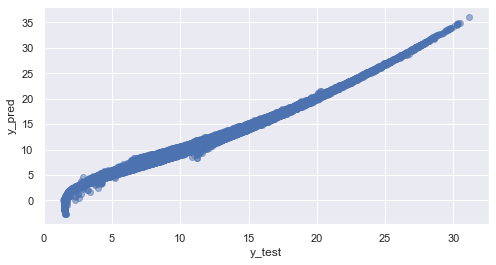

In [77]:
compare_three(y_test,y_pred,y_train,y_pred_train)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')